In [11]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Sample data
orders = np.array([[1,'apple'], [1,'egg'], [1,'milk'], [2,'egg'], [2,'milk']], dtype=object)


# Generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    
    # For each order, generate a list of items in that order
    for order_id, order_object in groupby(orders, lambda x: x[0]):
        
        item_list = [item[1] for item in order_object]     
        # For each item list, generate item pairs, one at a time
        for item_pair in combinations(item_list, 2):#아이템 리스트로 만들 수 있는 모든 조합 구하기
            yield item_pair                                      


# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
Counter(get_item_pairs(orders))

#이렇게 하면 좋은게 메모리 사용이 덜하다.
#(이 접근 방식을 사용하면 카운트가 업데이트된 후 항목 쌍이 삭제되므로 메모리를 많이 사용하지 않게 된다.)

Counter({('apple', 'egg'): 1, ('apple', 'milk'): 1, ('egg', 'milk'): 2})

모든 항목집합에 대한 지지도를 계산하는 대신에 최소 지지도 이상의 빈발항목집합만을 찾아내서 연관규칙을 계산하는 것이 Apriori algorithm의 주요 내용입니다. 

출처: https://rfriend.tistory.com/192 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

# 최소 발생 임계값 3 으로 가정

order 1: apple, egg, milk  
order 2: carrot, milk  
order 3: apple, egg, carrot  
order 4: apple, egg  
order 5: apple, carrot


Iteration 1:  Count the number of times each item occurs   
item set      occurrence count    
{apple}              4   
{egg}                3   
{milk}               2   
{carrot}             2   

{milk} and {carrot} are eliminated because they do not meet the minimum occurrence threshold.


Iteration 2: Build item sets of size 2 using the remaining items from Iteration 1 
             (ie: apple, egg)  
item set           occurence count  
{apple, egg}             3  

Only {apple, egg} remains and the algorithm stops since there are no more items to add.


#같이 발생한것만 세는듯

# 지지도

이것은 항목 집합이 포함된 주문의 백분율입니다. 위의 예에서는 총 5개의 주문이 있으며 그 중 3개에서 {apple,egg}개가 발생하므로 다음과 같습니다.

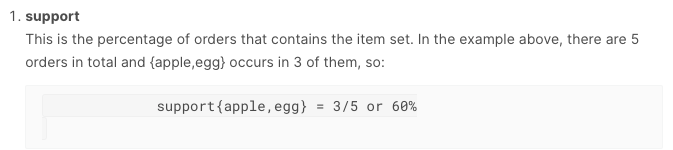

# 신뢰도

A와 B라는 두 가지 항목을 고려했을 때, A는 구매했다는 점에서 B는 구매 횟수에 대한 신뢰도를 측정한다. 이는 다음과 같이 표현된다.

즉, A를 구매했을때 B를 구매할 확률

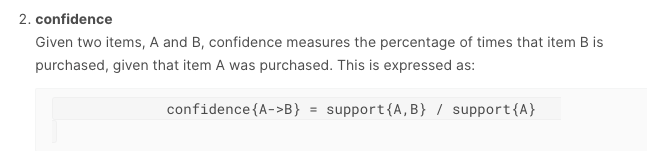

이건 반대 B->A

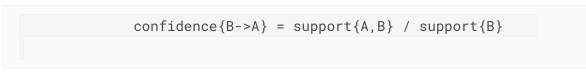

우리 데이터로 구한 신뢰도 예제

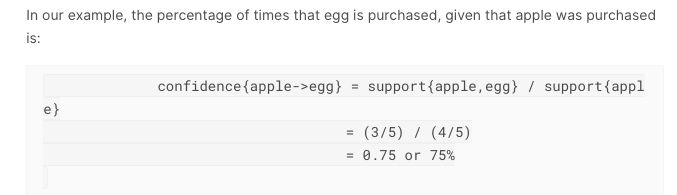

사과 샀을때, 계란 같이 구매할 확률 75%

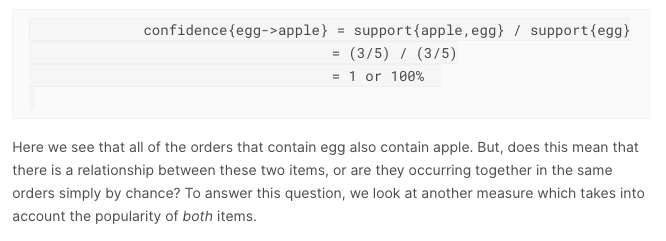

계란 샀을때, 사과 같이 구매할 확률 100%, 이게 우연인지 아닌지 정확히 알기위해
다른 방법으로 알아봄

## 향상도

향상도는 신뢰도랑 다르게 방향성이 없음,

품목 B를 구매한 고객 대비 품목 A를 구매한 후 품목 B를 구매하는 고객에 대한 확률을 의미함

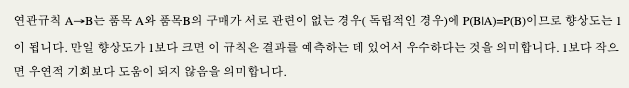

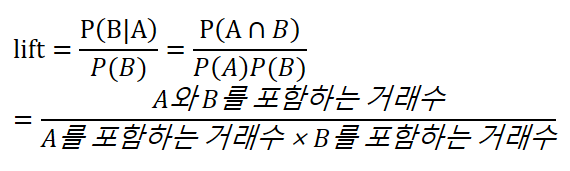

우리 데이터 예제

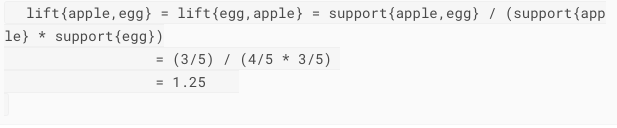

1.25가 나오므로, 계란과 사과는 서로 긍정적인 관계를 가진 데이터라고 볼 수 있음

# Input Dataset

In [12]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [13]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [14]:
orders = pd.read_csv('Data/order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

# index를 order_id로 설정하고, 설정된 데이터에서 product_id 컬럼 가져오는데 
# 이름은 item_id로 가져오겠다.

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [16]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,);   size: 518.95 MB;   unique_orders: 3214874;   unique_items: 49677


In [17]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
#             combinations == 하나의 list에서 모든 조합 찾아냄
            yield item_pair
#             이터레이터는 모든 동작을 완료한 후 결과를 한번에 메모리 적재 시키는것에 반해, 
#             제너레이터는 각각의 yield에서 한번 실행 시킨 후 대기 상태에 들어가 결과를 반환

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]      

In [18]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")#컬럼명 지정
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [19]:
%%time
rules = association_rules(orders, 0.01)  

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716


AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [20]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('Data/products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

NameError: name 'rules' is not defined